# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import mrcfile
import time

from simplecryoem.utils import *
from simplecryoem.projection import *
from simplecryoem.interpolate import *
from simplecryoem.jaxops import *
from simplecryoem.noise import estimate_noise_radial
from simplecryoem.fsc import *
from simplecryoem.algorithm import *
from simplecryoem.ab_initio import ab_initio_mcmc
from simplecryoem.residual import get_volume_residual
from simplecryoem.preprocess import *


plt.rcParams["figure.figsize"]=6,6

In [26]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"
#star_file = "Projections/crossvalidation1/crossvalidation1.star"
#star_file = "Projections/crossvalidation1_zeros/crossvalidation1_zeros.star"
star_file = "particles_crossvalidation_test_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  26380
load_data: data loaded, time:  37.225690841674805


In [30]:
out_dir = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/data/out_dev/"

In [31]:
nx_crop = 128
N_px_noise = 48
N_imgs_noise= 5000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop,  N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (26380, 320, 320)
pixel_size0.shape = (26380,)
angles0.shape = (26380, 3)
shifts0.shape = (26380, 2)
ctf_params0.shape = (26380, 9)
Shuffle = False
N = 26380
Taking FFT of the images...done. Time: 72.05159831047058 seconds.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (26380, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 5000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time: 11.860321521759033 seconds.


### Plot a few things

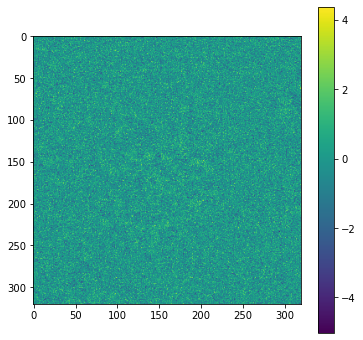

In [32]:
idx =123
plt.imshow(imgs0[idx]);plt.colorbar()

Text(0.5, 1.0, 'Estimated noise')

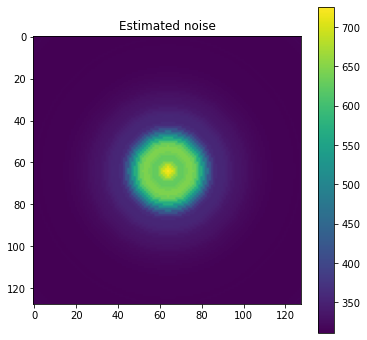

In [33]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx, nx]))); plt.colorbar()
plt.title('Estimated noise')

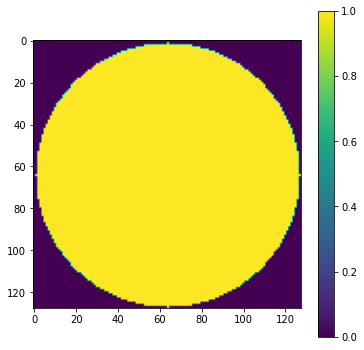

In [34]:
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Get residual

In [35]:
N_batches = 600 # for full dataset and 64

vol, vol_sigma, vol_counts = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 20.25114893913269 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.6705658435821533 seconds.
Batch 10, 0.13624143600463867 seconds.
Batch 20, 0.13514447212219238 seconds.
Batch 30, 0.1394505500793457 seconds.
Batch 40, 0.13412117958068848 seconds.
Batch 50, 0.14353656768798828 seconds.
Batch 60, 0.13553428649902344 seconds.
Batch 70, 0.1533677577972412 seconds.
Batch 80, 0.1397411823272705 seconds.
Batch 90, 0.15182757377624512 seconds.
Batch 100, 0.13973355293273926 seconds.
Batch 110, 0.1554412841796875 seconds.
Batch 120, 0.1667327880859375 seconds.
Batch 130, 0.1522684097290039 seconds.
Batch 140, 0.13650083541870117 seconds.
Batch 150, 0.1386713981628418 seconds.
Batch 160, 0.13554167747497559 seconds.
Batch 170, 0.1533668041229248 seconds.
Batch 180, 0.15025973320007324 seconds.
Batch 190, 0.15551495552062988 seconds.
Batch 200, 0.16695570945739746 seconds.
Batch

In [33]:
vol0, vol0_sigma, vol0_counts = get_volume_residual(jnp.abs(imgs0_f), angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 19.606279611587524 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.5334970951080322 seconds.
Batch 10, 0.03874707221984863 seconds.
Batch 20, 0.03918313980102539 seconds.
Batch 30, 0.04102063179016113 seconds.
Batch 40, 0.03888344764709473 seconds.
Batch 50, 0.03871870040893555 seconds.
Batch 60, 0.03895282745361328 seconds.
Batch 70, 0.03905653953552246 seconds.
Batch 80, 0.039167165756225586 seconds.
Batch 90, 0.03887820243835449 seconds.
Batch 100, 0.03859376907348633 seconds.
Batch 110, 0.03895092010498047 seconds.
Batch 120, 0.03957676887512207 seconds.
Batch 130, 0.03873872756958008 seconds.
Batch 140, 0.03902125358581543 seconds.
Batch 150, 0.03940892219543457 seconds.
Batch 160, 0.0393824577331543 seconds.
Batch 170, 0.042903900146484375 seconds.
Batch 180, 0.03877568244934082 seconds.
Batch 190, 0.038956642150878906 seconds.
Batch 200, 0.03924918174743652 sec

In [26]:
vold, vold_sigma, vold_counts = get_volume_residual(jnp.abs(imgs_f-imgs0_f), angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 20.218420267105103 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.6910216808319092 seconds.
Batch 10, 0.039392709732055664 seconds.
Batch 20, 0.039270877838134766 seconds.
Batch 30, 0.03950309753417969 seconds.
Batch 40, 0.039017677307128906 seconds.
Batch 50, 0.03926658630371094 seconds.
Batch 60, 0.03873443603515625 seconds.
Batch 70, 0.039263010025024414 seconds.
Batch 80, 0.03908991813659668 seconds.
Batch 90, 0.03877878189086914 seconds.
Batch 100, 0.0386660099029541 seconds.
Batch 110, 0.04196429252624512 seconds.
Batch 120, 0.039426326751708984 seconds.
Batch 130, 0.03926897048950195 seconds.
Batch 140, 0.04100537300109863 seconds.
Batch 150, 0.03891706466674805 seconds.
Batch 160, 0.03899240493774414 seconds.
Batch 170, 0.039479732513427734 seconds.
Batch 180, 0.03915715217590332 seconds.
Batch 190, 0.04610490798950195 seconds.
Batch 200, 0.03907585144042969 

In [39]:
print(jnp.real(jnp.max(vold)))
print(jnp.real(jnp.max(vol0)))

803.662353515625
913.9186127661757


In [72]:
resid_abs = jnp.real(jnp.fft.fftshift(vold))
resid0_abs = jnp.real(jnp.fft.fftshift(vol0))
resid_sig_abs = jnp.real(jnp.fft.fftshift(vold/(vol0_sigma+1)))
resid0_sig_abs = jnp.real(jnp.fft.fftshift(vol0/(vol0_sigma+1)))

In [73]:
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid_abs.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid0_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0_abs.astype(np.float32))
    
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid_sig_abs.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid0_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0_sig_abs.astype(np.float32))

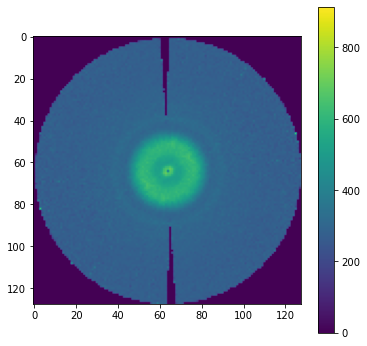

In [62]:
plt.imshow(resid_abs, vmax=914); plt.colorbar()

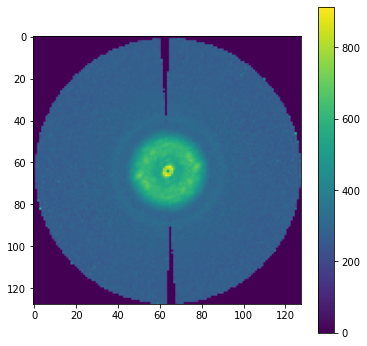

In [63]:
plt.imshow(resid0_abs, vmax=914); plt.colorbar()

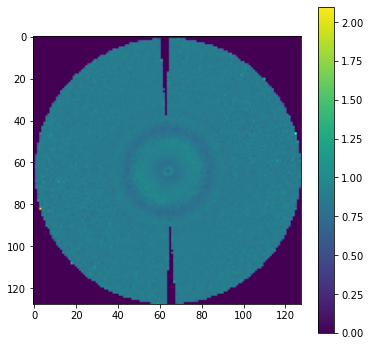

In [64]:
plt.imshow(resid_sig_abs); plt.colorbar()

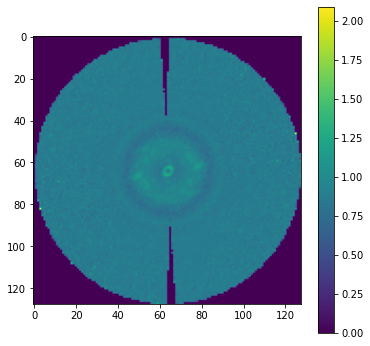

In [65]:
plt.imshow(resid0_sig_abs); plt.colorbar()

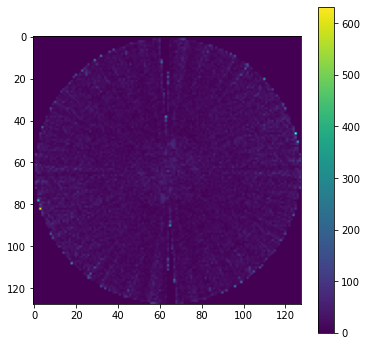

In [31]:
plt.imshow(jnp.abs(jnp.fft.fftshift((vol0[0]-vol[0])))); plt.colorbar()

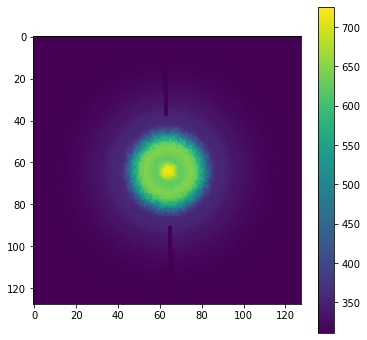

In [29]:
plt.imshow(jnp.fft.fftshift(vol_sigma[0]), vmin=jnp.min(sigma_noise_avg)); plt.colorbar()

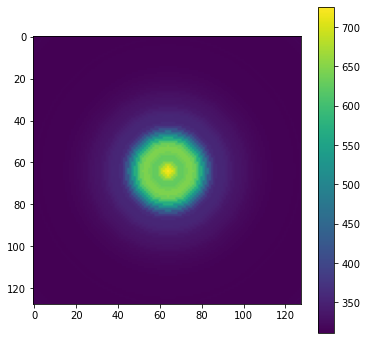

In [30]:
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

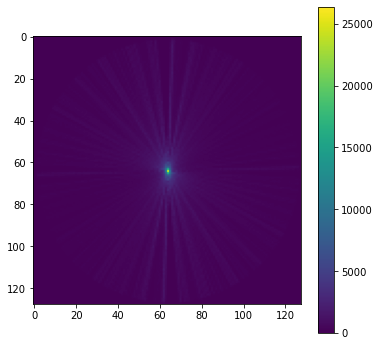

In [221]:
plt.imshow(jnp.fft.fftshift(vol_counts[0])); plt.colorbar()

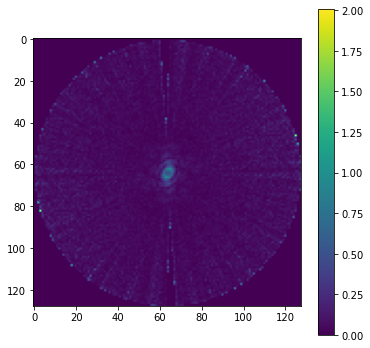

In [222]:
vs = vol/(vol_sigma+1e-16)

plt.imshow(jnp.abs(jnp.fft.fftshift(vs[0]))); plt.colorbar()

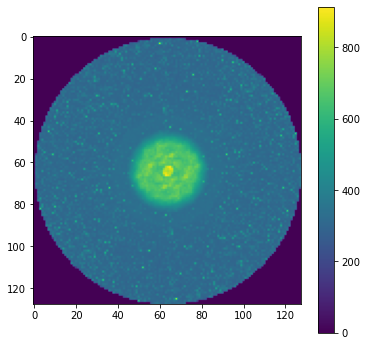

In [35]:
mip_x(jnp.abs(jnp.fft.fftshift(vol0))); plt.colorbar()

In [179]:
N = 10
A = jnp.zeros([N, N, N])
#A = A.at[0,0,0].set(2000)
#A = A.at[0,0,1].set(3000)

In [180]:
x = jnp.array([0,0,0])
y = jnp.array([0,0,0])
z = jnp.array([0,1,1])

xyz = jnp.ravel_multi_index((x,y,z), dims = A.shape)

In [181]:
B = A.reshape(-1).at[xyz].set([8880,9990, 3]).reshape([N,N,N])

In [73]:
@jax.jit
def myfunc(B):
    return jnp.matmul(A, B)

In [83]:
myfunc2 = jax.jit(lambda C : jnp.matmul(A, C))

In [81]:
t0 = time.time()
bb = myfunc(B)
bb.block_until_ready()
print(time.time()-t0)

0.30991482734680176


In [89]:
t0 = time.time()
bb = myfunc2(B)
bb.block_until_ready()
print(time.time()-t0)

0.3027036190032959


In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid3[0]))); plt.colorbar()

NameError: name 'v_resid3' is not defined

In [208]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

NameError: name 'v_resid' is not defined

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/cryodrgn_crossvalidation/v_resid_cv2_128.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [45]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_64.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_64_proj.mrc').data

In [36]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(5041074., dtype=float32)

In [25]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_128.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_128.mrc').data


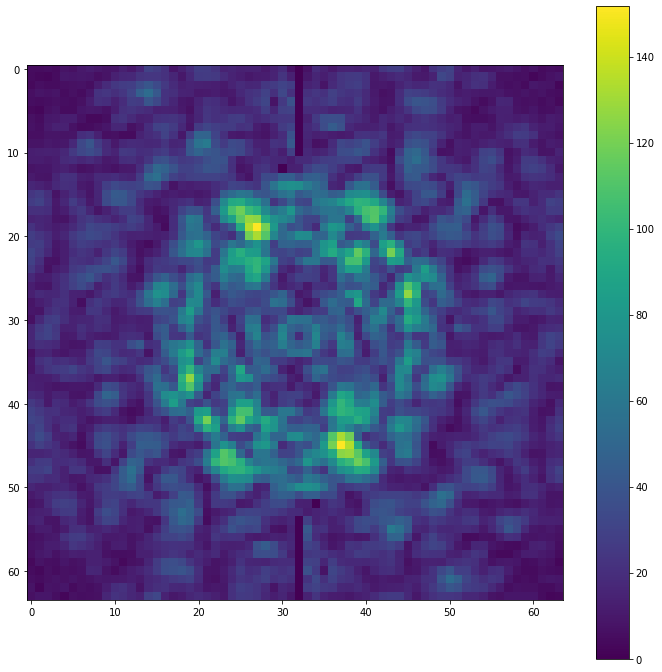

In [49]:
plt.imshow(rv[:,:,32]); plt.colorbar()

In [32]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(0., dtype=float32)

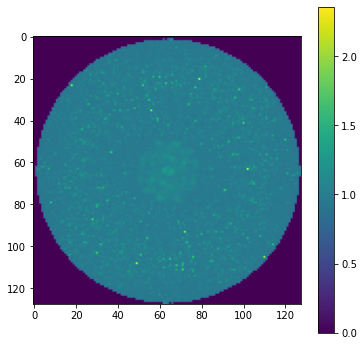

In [30]:
mip_z(rv); plt.colorbar()

### Read the Fourier volumes and divide by $\sigma_{noise}$

In [58]:
cvidx = 12
nx = 128

In [59]:
with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_imgs.mrc") as file:
    # Call load method to deserialze
    vol_img = file.data

with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_resid.mrc") as file:
    # Call load method to deserialze
    vol_resid = file.data
    
with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_sigma.mrc") as file:
    # Call load method to deserialze
    vol_sigma = file.data
    
with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_counts.mrc") as file:
    # Call load method to deserialze
    vol_counts = file.data

In [60]:
vol_resid_sig = vol_resid/(vol_sigma + 1e-14)
vol_img_sig = vol_img/(vol_sigma + 1e-14)

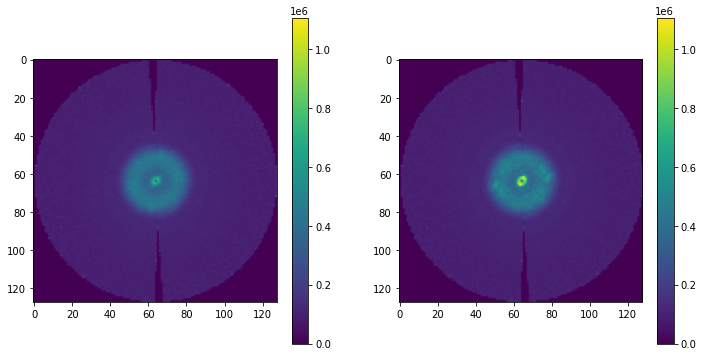

In [61]:
plt.rcParams["figure.figsize"]=12,6

vmax = jnp.max(jnp.abs(vol_img))

plt.subplot(1,2,1)
plt.imshow(jnp.abs(vol_resid[64]), vmax=vmax); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(jnp.abs(vol_img[64]), vmax=vmax); plt.colorbar()

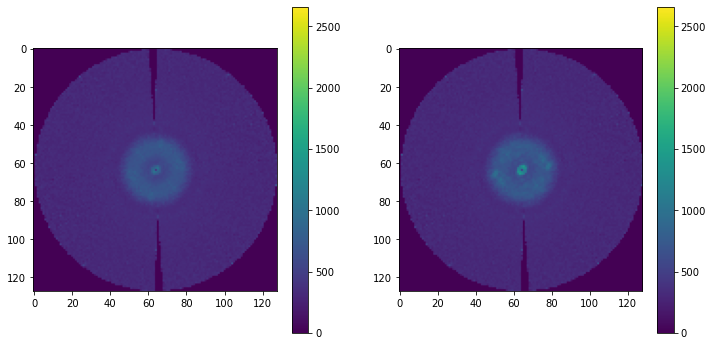

In [62]:
plt.rcParams["figure.figsize"]=12,6

vmax_sig = jnp.max(jnp.abs(vol_img_sig))

plt.subplot(1,2,1)
plt.imshow(jnp.abs(vol_resid_sig[64]), vmax=vmax_sig); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(jnp.abs(vol_img_sig[64]), vmax=vmax_sig); plt.colorbar()

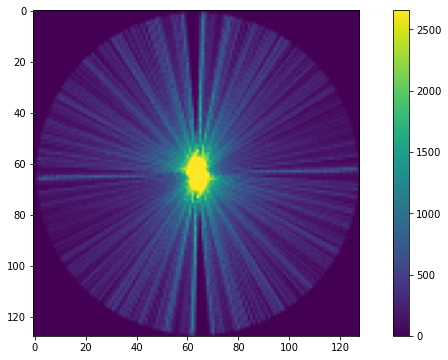

In [63]:
plt.imshow(jnp.abs(vol_counts[64]), vmax=vmax_sig); plt.colorbar()


In [64]:
with mrcfile.new(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_imgs_sig.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_img_sig.astype(np.float32))
    
with mrcfile.new(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_resid_sig.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_resid_sig.astype(np.float32))  

### Read all volumes and average

In [66]:
nx = 128
cv_indices = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
save_to_file = False

In [67]:
vols_img = []
vols_resid = []
vols_counts = []
vols_sigma = []
for cvidx in cv_indices:
    with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_imgs_sig.mrc") as file:
        # Call load method to deserialze
        vols_img.append(file.data)

    with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_resid_sig.mrc") as file:
        # Call load method to deserialze
        vols_resid.append(file.data)
    
    with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_sigma.mrc") as file:
        # Call load method to deserialze
        vols_sigma.append(file.data)
    
    with mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_{nx}_counts.mrc") as file:
        # Call load method to deserialze
        vols_counts.append(file.data)
        
vols_img = jnp.array(vols_img)
vols_resid = jnp.array(vols_resid)
vols_counts = jnp.array(vols_counts)
vols_sigma = jnp.array(vols_sigma)

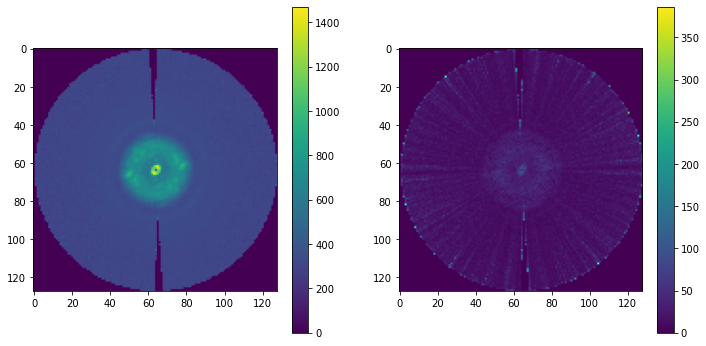

In [68]:
vol_img_avg = jnp.mean(vols_img, axis=0)
vol_img_std = jnp.std(vols_img, axis=0)

plt.rcParams["figure.figsize"]=12,6

vmax_avg = jnp.max(jnp.abs(vol_img_avg))
vmax_std = jnp.max(jnp.abs(vol_img_std))


plt.subplot(1,2,1)
plt.imshow(jnp.abs(vol_img_avg[64]), vmax=vmax_avg); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(jnp.abs(vol_img_std[64])); plt.colorbar()

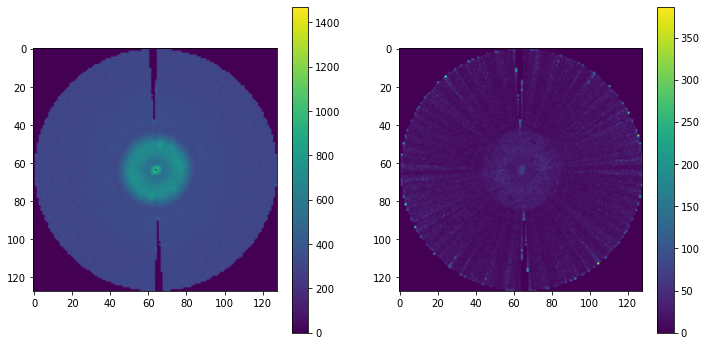

In [69]:
vol_resid_avg = jnp.mean(vols_resid, axis=0)
vol_resid_std = jnp.std(vols_resid, axis=0)

plt.rcParams["figure.figsize"]=12,6

#vmax_sig = jnp.max(jnp.abs(vol_img_sig))

plt.subplot(1,2,1)
plt.imshow(jnp.abs(vol_resid_avg[64]), vmax=vmax_avg); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(jnp.abs(vol_resid_std[64])); plt.colorbar()

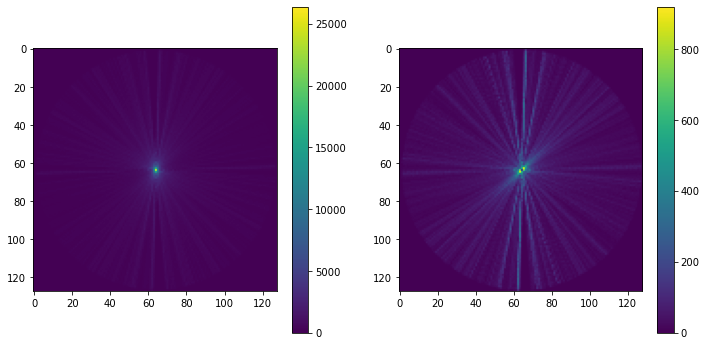

In [70]:
vol_counts_avg = jnp.mean(vols_counts, axis=0)
vol_counts_std = jnp.std(vols_counts, axis=0)

plt.rcParams["figure.figsize"]=12,6

#vmax_sig = jnp.max(jnp.abs(vol_img_sig))

plt.subplot(1,2,1)
plt.imshow(jnp.abs(vol_counts_avg[64])); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(jnp.abs(vol_counts_std[64])); plt.colorbar()

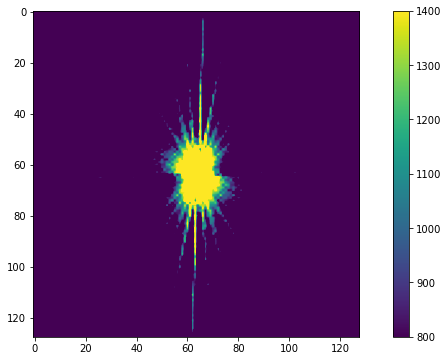

In [71]:
plt.imshow(vol_counts_avg[64], vmin=800, vmax=1400); plt.colorbar()

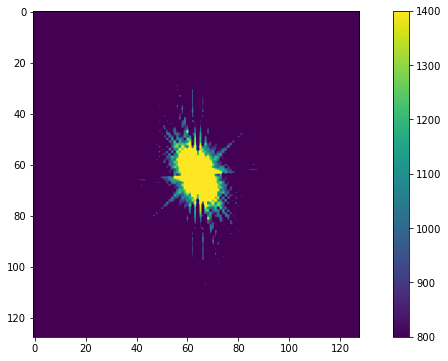

In [72]:
plt.imshow(vol_counts_avg[:,64], vmin=800, vmax=1400); plt.colorbar()

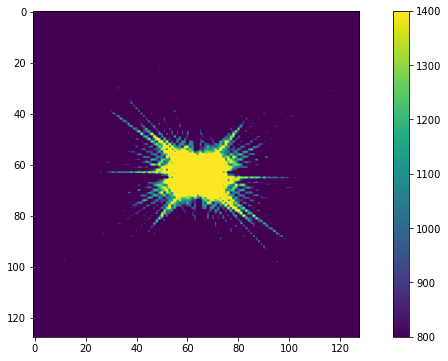

In [73]:
plt.imshow(vol_counts_avg[:,:,64], vmin=800, vmax=1400); plt.colorbar()

In [74]:
vols_counts.shape

(11, 128, 128, 128)

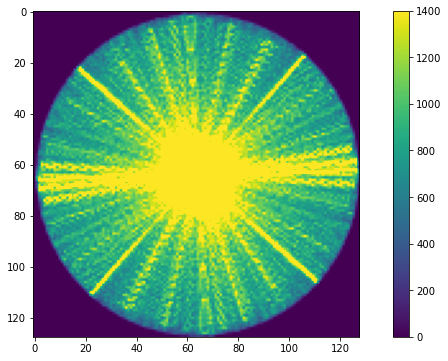

In [75]:
plt.imshow(jnp.max(vols_counts[0], axis=2), vmax=1400); plt.colorbar()

In [81]:
#save_to_file = True

In [80]:
if save_to_file:
    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_imgs_mean.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_img_avg.astype(np.float32))

    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_imgs_std.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_img_std.astype(np.float32))  

    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_resid_mean.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_resid_avg.astype(np.float32))

    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_resid_std.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_resid_std.astype(np.float32))  


    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_counts_mean.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_counts_avg.astype(np.float32))

    with mrcfile.new(f"../data/cryodrgn_crossvalidation/stats/cv_relion_{nx}_counts_std.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_counts_std.astype(np.float32))  

### Replicating the straight lines

In [109]:
N

26380

In [245]:
N_batches = 600 # for full dataset and 64
Nn = 10000
vol, vol_sigma, vol_counts = get_volume_residual(imgs_f[:10000], myangles, sigma_noise, x_grid, radius, N_batches)



Rotate each image and get list of coords. 10000 images in 10 batches...done in 7.868835687637329 seconds.
Average residuals in each voxel. 124850000 residuals in 600 batches.
Batch 0, 0.5251693725585938 seconds.
Batch 10, 0.029352903366088867 seconds.
Batch 20, 0.03002619743347168 seconds.
Batch 30, 0.029748916625976562 seconds.
Batch 40, 0.02933645248413086 seconds.
Batch 50, 0.029796123504638672 seconds.
Batch 60, 0.03235626220703125 seconds.
Batch 70, 0.029727458953857422 seconds.
Batch 80, 0.03322625160217285 seconds.
Batch 90, 0.029738664627075195 seconds.
Batch 100, 0.03024148941040039 seconds.
Batch 110, 0.030985116958618164 seconds.
Batch 120, 0.02999734878540039 seconds.
Batch 130, 0.02968144416809082 seconds.
Batch 140, 0.030325651168823242 seconds.
Batch 150, 0.034458160400390625 seconds.
Batch 160, 0.03443431854248047 seconds.
Batch 170, 0.029779434204101562 seconds.
Batch 180, 0.034220218658447266 seconds.
Batch 190, 0.03176569938659668 seconds.
Batch 200, 0.37190985679626

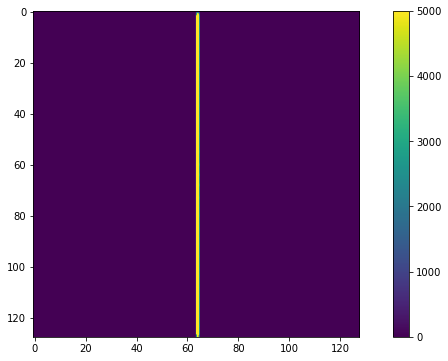

In [255]:
plt.imshow(jnp.max(jnp.fft.fftshift(vol_counts), axis=1), vmax=5000); plt.colorbar()

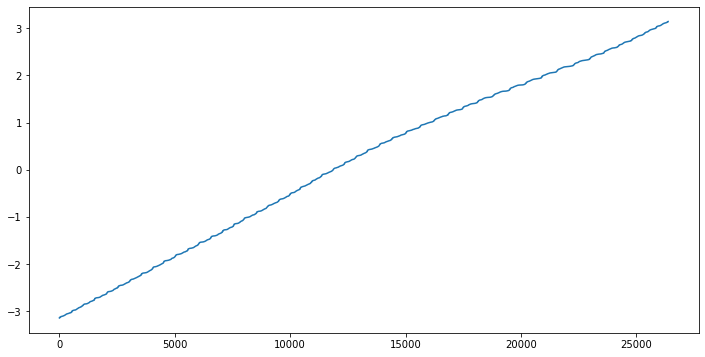

In [175]:
plt.plot(jnp.sort(angles[:,0]))

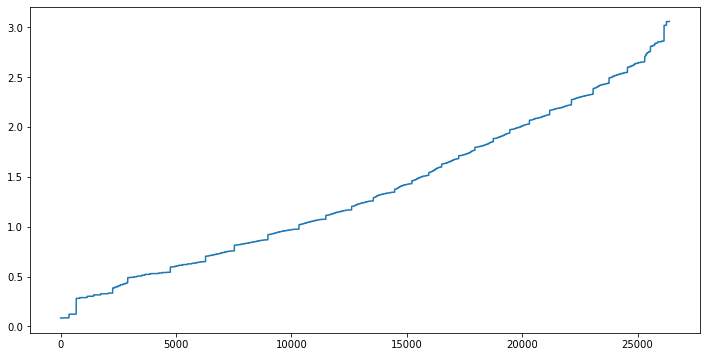

In [178]:
plt.plot(jnp.sort(angles[:,1]))

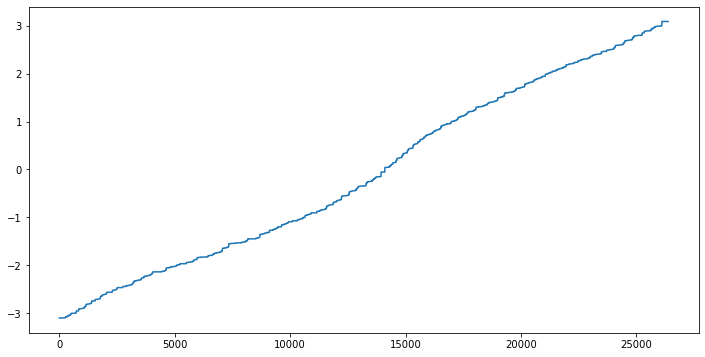

In [179]:
plt.plot(jnp.sort(angles[:,2]))

In [229]:
#idxs = jnp.arange(0, 25000, 100)
idxs = jnp.arange(20340,21180) 
sortidxs = jnp.argsort(angles[:,1])
sortidxs_s = sortidxs[idxs]

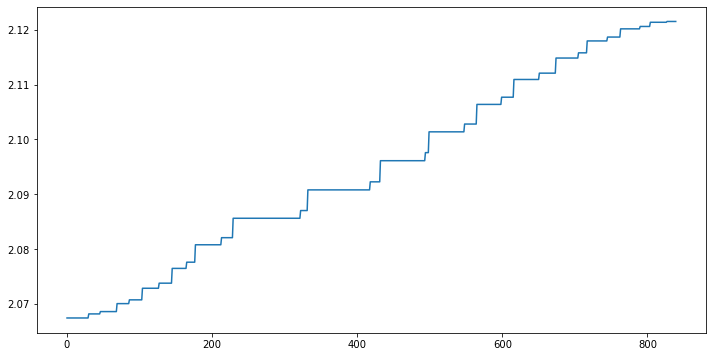

In [231]:
plt.plot(angles[sortidxs_s,1])

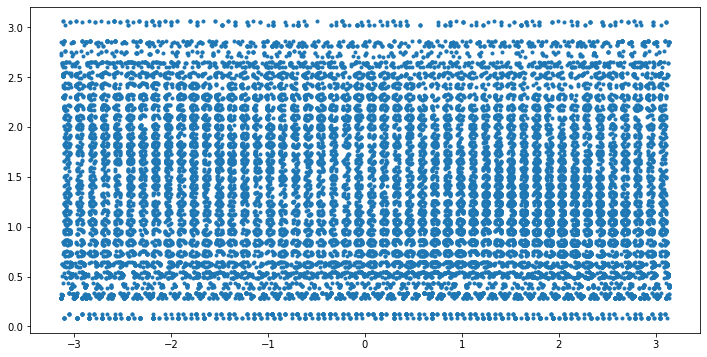

In [256]:
plt.plot(angles[:,0], angles[:,1], '.')

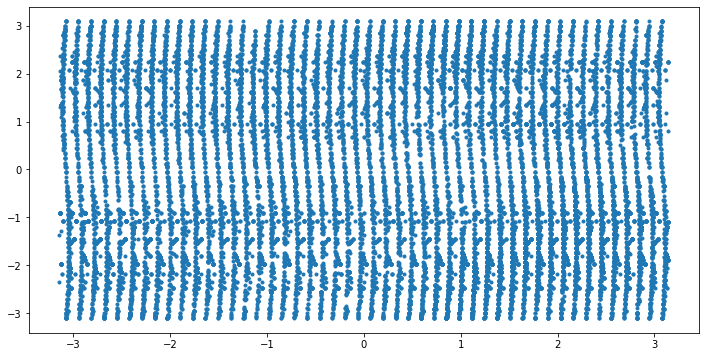

In [257]:
plt.plot(angles[:,0], angles[:,2], '.')

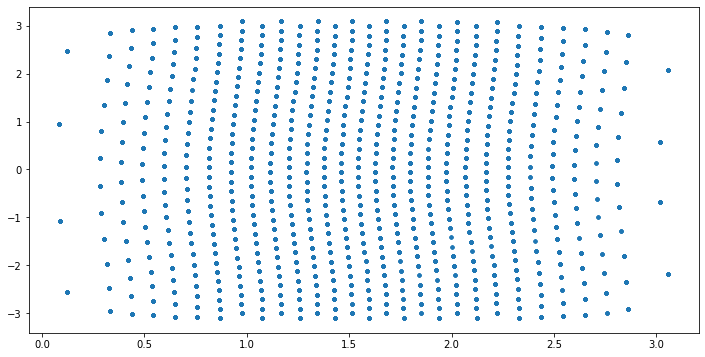

In [258]:
plt.plot(angles[:,1], angles[:,2], '.')

In [243]:
myangles = np.array(generate_uniform_orientations(10000))
myangles[:,1] = 0
myangles[:,2] = 0

In [244]:
myangles

array([[4.52314522, 0.        , 0.        ],
       [1.30867035, 0.        , 0.        ],
       [3.40889442, 0.        , 0.        ],
       ...,
       [2.85593217, 0.        , 0.        ],
       [2.01059368, 0.        , 0.        ],
       [0.43758927, 0.        , 0.        ]])